# Exercise 5

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Contents

- Custom DataLoaders
- Learning Rate Schedules
- Weight Initalizations
- BatchNormalization

## Custom DataLoaders

### Task 1: Defining your own DataLoader with z-score normalisation
- Define a new Class `WineDataset` which inherits from class `torch.utils.data.Dataset` and load the `wine.csv` file correctly. To do so, overwrite the `__init__`, `__len__` and `__getitem__` function of the class you created
- Within the `__init__` function make it so that your data is z-score normalised, i.e. each record is zero-centered and normalised.

In [2]:
from torch.utils.data import Dataset

class WineDataset(Dataset):
    def __init__(self, path, range_data):
        # Loading data
        data = np.loadtxt(path, delimiter=",")
        
        # Shuffeling data (need this because dataset is ordered)
        np.random.shuffle(data)
        
        ## Z-score normalization
        # Zero-centering & normalisation (variance will be 1)
        mean = np.mean(data[:, 1:])
        std = np.std(data[:, 1:])
        
        data[:, 1:] = (data[:, 1:] - mean) / std
        
        # Store data as parameter
        self.data = data[range_data, :]
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx, 1:].T, int(self.data[idx, 0])-1
    
training_set = WineDataset('wine.csv', range(140))
validation_set = WineDataset('wine.csv', range(140,170))

train_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

### Take-Home Assignment 1
- Write a similar DataLoader for the Wine Quality dataset from Exercise 1. Apply now z-score normalization per column(!).

In [7]:
from torch.utils.data import Dataset

class WineQualityDataset(Dataset):
    def __init__(self, path, range_data):
        # Loading data
        data = np.loadtxt(path, delimiter=";", skiprows=1)

        # Shuffeling data (need this because dataset is ordered)
        np.random.shuffle(data)
        
        # Split into features and labels
        X = data[:, :-1]
        y = data[:, -1]
                
        ## Z-score normalization per axis
        # Zero-centering & normalisation (variance will be 1)
        for axis in range(X.shape[1]):
            mean_axis = np.mean(X[:, axis])
            std_axis = np.std(X[:, axis])
            X[:, axis] = (X[:, axis] - mean_axis) / std_axis

        self.data = np.concatenate((X[range_data, :], y[range_data][:, None]), axis=1)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx, :-1].T, int(self.data[idx, -1])
    
training_set = WineQualityDataset('winequality.csv', range(2000))
validation_set = WineQualityDataset('winequality.csv', range(2000,4898))

print(len(training_set), len(validation_set))
print(training_set[0])
print(validation_set[0])

2000 2898
(array([ 1.00169505,  0.21589563,  0.70911744,  1.55940506, -0.035355  ,
        0.56993158,  1.75647912,  1.69618834, -0.05475133,  1.22818321,
       -1.06808001]), 5)
(array([-1.13155718, -0.37943543,  0.04800112, -0.86589377, -0.40155916,
        0.27590734, -0.71447388, -1.52055577,  0.01148034,  0.08897337,
        1.45123145]), 6)


### Task 2: Learning Rate Schedules

- Extend the train loop as you know it from previous exercises such that it lowers the learning rate after 10 epochs by a factor of 10.

In [8]:
class LinearClassificationNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(13, 3)
    
    def forward(self, x):
        x = self.layer1.forward(x)
        return x
    

def train_loop_schedule(train_loader, val_loader, network, loss_fun, optimizer, epochs, print_freq=1):
    for e in range(epochs):
        train_loss = 0.

        # Training
        for i, (x, y) in enumerate(train_loader):
            x, y = x.float(), y.long()
            
            # Prediction
            y_pred = network.forward(x)
            batch_loss = loss_fun(y_pred, y)
            train_loss += batch_loss
            
            # Optimization
            network.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        # Inference
        val_loss = 0.
        with torch.no_grad():
            for i, (x, y) in enumerate(val_loader):
                x, y = x.float(), y.long()
                y_pred = network.forward(x)
                val_loss += loss_fun(y_pred, y)
        
        # Print epoch results only every print_freq iterations
        if (e + 1) % print_freq == 0:
            print("Epoch: {}/{}; Training loss: {}; Validation loss {}"
                  .format(e+1, epochs, train_loss / len(train_loader), val_loss / len(val_loader)))
        
        # Check if learning rate should be decreased
        if (e + 1) % 10 == 0 and (e + 1) < epochs:
            optimizer.param_groups[0]['lr'] *= 0.1
            print("Decreased LR to {}!".format(optimizer.param_groups[0]['lr']))

            

Test your implementation!

In [9]:
epochs = 30
lr = 0.1

loss_fun = nn.CrossEntropyLoss()
network = LinearClassificationNet()
optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)

train_loop_schedule(train_loader, val_loader, network, loss_fun, optimizer, epochs)

/home/nd/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1/30; Training loss: 0.9209780097007751; Validation loss 0.9825673699378967
Epoch: 2/30; Training loss: 1.0146933794021606; Validation loss 0.5416669845581055
Epoch: 3/30; Training loss: 1.2383995056152344; Validation loss 2.9227349758148193
Epoch: 4/30; Training loss: 0.8499841690063477; Validation loss 0.5784255266189575
Epoch: 5/30; Training loss: 0.8991178274154663; Validation loss 1.011553168296814
Epoch: 6/30; Training loss: 0.9518823027610779; Validation loss 0.5507366061210632
Epoch: 7/30; Training loss: 0.8346145153045654; Validation loss 0.6381974220275879
Epoch: 8/30; Training loss: 0.7683371305465698; Validation loss 0.573447048664093
Epoch: 9/30; Training loss: 0.7606141567230225; Validation loss 0.5160219073295593
Epoch: 10/30; Training loss: 0.8521071076393127; Validation loss 1.0358778238296509
Decreased LR to 0.010000000000000002!
Epoch: 11/30; Training loss: 0.713813304901123; Validation loss 0.5351976752281189
Epoch: 12/30; Training loss: 0.6170434355735779; V

### Take-Home Assignment 2

- Now, extend the train loop such that it lowers the learning rate if the network has not improved in 5 epochs. To do so you need to track the current best loss that you have achieved so far as well as during which epoch said loss occured.

In [12]:
def train_loop_plateau(train_loader, val_loader, network, loss_fun, optimizer, epochs, print_freq=1):
    # Track best loss and best epoch
    best_loss, best_epoch = 0., 0
    for e in range(epochs):
        train_loss = 0.

        # Training
        for i, (x, y) in enumerate(train_loader):
            x, y = x.float(), y.long()
            
            # Prediction
            y_pred = network.forward(x)
            batch_loss = loss_fun(y_pred, y)
            train_loss += batch_loss
            
            # Optimization
            network.zero_grad()
            batch_loss.backward()
            optimizer.step()
        
        # Inference
        val_loss = 0.
        with torch.no_grad():
            for i, (x, y) in enumerate(val_loader):
                x, y = x.float(), y.long()
                y_pred = network.forward(x)
                val_loss += loss_fun(y_pred, y)
        
        # Print epoch results only every print_freq iterations
        if (e + 1) % print_freq == 0:
            print("Epoch: {}/{}; Training loss: {}; Validation loss {}"
                  .format(e+1, epochs, train_loss / len(train_loader), val_loss / len(val_loader)))
        
        # If current loss is lower than best loss, store pointer to said epoch
        if e == 0:
            best_loss = train_loss
            best_epoch = e
        elif best_loss > train_loss:
            best_loss = train_loss
            best_epoch = e

        # Decrease learning rate if loss has not been improved over 5 epochs
        if best_epoch + 4 == e:
            optimizer.param_groups[0]['lr'] *= 0.1
            print("Decreased LR to {}!".format(optimizer.param_groups[0]['lr']))

            

## Weight Initalization

During lecture you saw undesirable property of networks, namely activations either drift apart or converge to zero the deeper we get in our network. This is undesireable as it complicates training. In general we want that activations live in the same distribution across layers. Will make our training more efficient. To demontrate you this consider the example below:

In [15]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(10, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.ReLU(),
                                    nn.Linear(100, 1, bias=False),
                                   )
    
    def forward(self, x):
        return self.layers(x)

def track_activations(activations):
    def hook_fun(module, input, output):
        activations.append(output.detach())
    return hook_fun

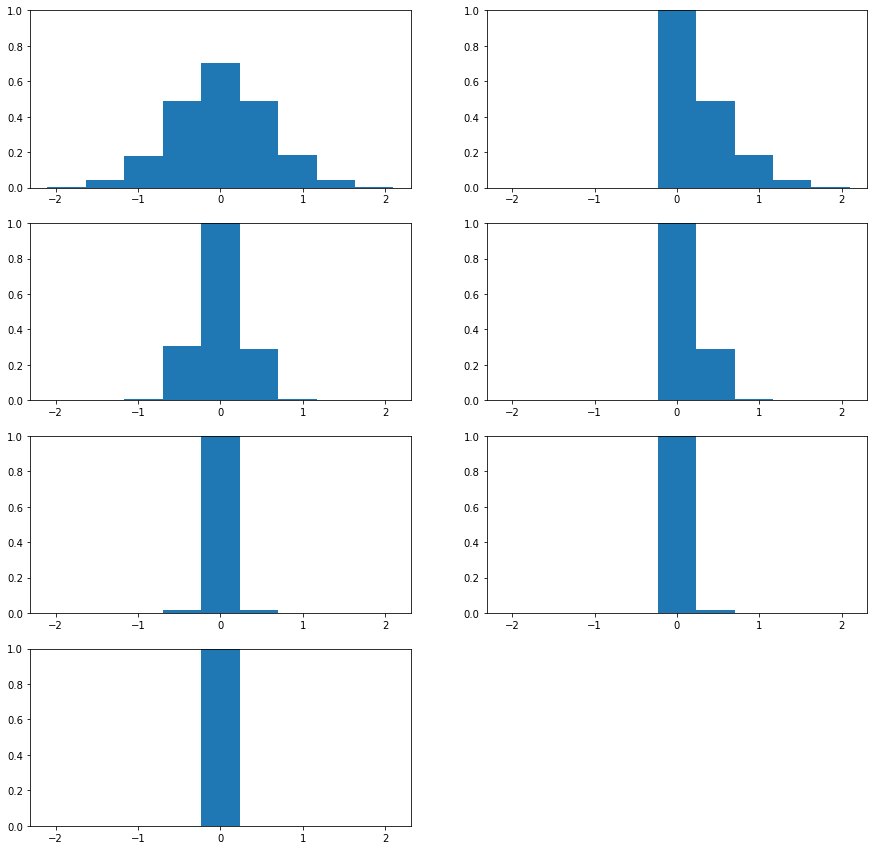

In [16]:
x = torch.randn(1000, 10)
net = Network()

hooks = []
activations = []
hook_fun = track_activations(activations)

for layer in net.layers:
    hook = layer.register_forward_hook(hook_fun)
    hooks.append(hook)

with torch.no_grad():
    res = net(x)

for hook in hooks:
    hook.remove()
    
plt.figure(figsize=(15, 15))

for i, act in enumerate(activations):
    plt.subplot(4, 2, i+1)
    plt.hist(act.reshape(-1).numpy(), bins=9, density=True, range=(-2.1,2.1))
    plt.gca().set_ylim(0, 1)
plt.show()

As you can see the activations get smaller and smaller the deeper we go in our network. To dampen this effect we can use weight initalization schemes. You got to know Kaiming He's initialization scheme. Using this scheme we make it so that activations across layers are approximately distributed in the same normal distribution.

### Task 3: Using Weight Initalization

Now, initalize the weights of your network before starting training! Use Kaiming He's initialisation which you know from the lecture (see https://pytorch.org/docs/stable/nn.init.html). Write the `init_weight` function which iteratively checks each module and initalizes the weights if the module is of type `nn.Linear`

In [46]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        
net.apply(init_weights)

Network(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=False)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=100, bias=False)
    (4): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=False)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=1, bias=False)
  )
)

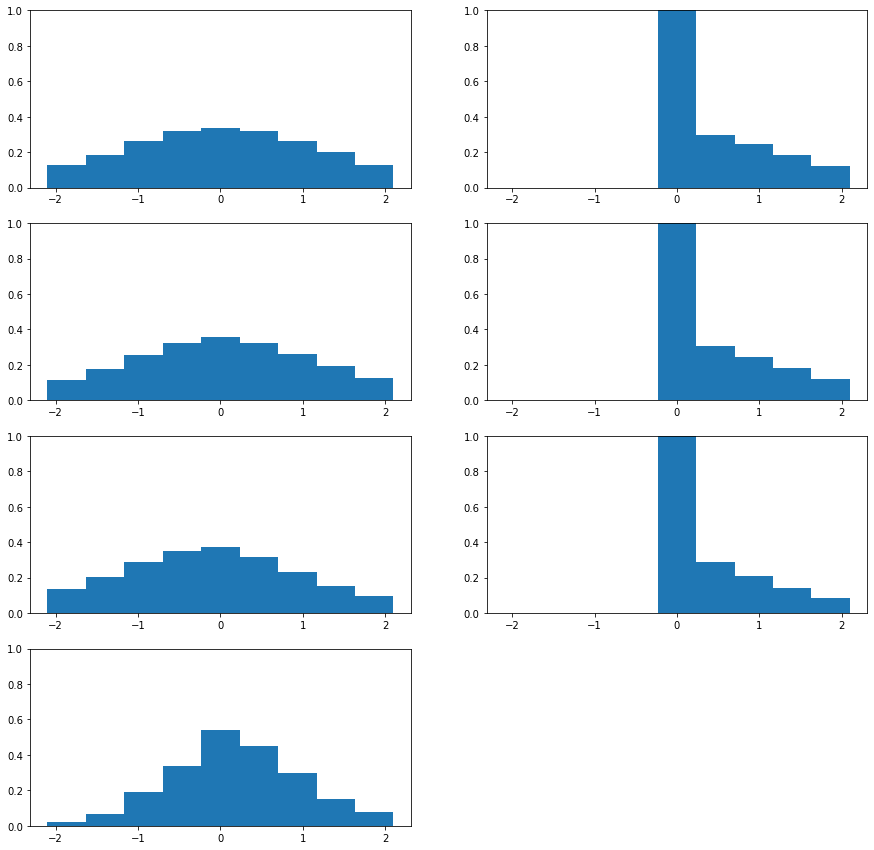

In [28]:
hooks = []
activations = []
hook_fun = track_activations(activations)

for layer in net.layers:
    hook = layer.register_forward_hook(hook_fun)
    hooks.append(hook)

with torch.no_grad():
    res = net(x)

for hook in hooks:
    hook.remove()
    
plt.figure(figsize=(15, 15))

for i, act in enumerate(activations):
    plt.subplot(4, 2, i+1)
    plt.hist(act.reshape(-1).numpy(), bins=9, density=True, range=(-2.1,2.1))
    plt.gca().set_ylim(0, 1)

## BatchNormalization

Batch Normalization is another way to ensure that activations across layers stay normally distributed. It more aggressive as in that it intermediatly normalizes the data again.

### Task 4: Using BatchNorm Layers

- Extend the network below by adding BatchNorm layers after each Linear layer. Use PyTorch's `BatchNorm1D` class (https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) to do so. See how the BatchNorm layer changes your data along the flow of your network.

In [31]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(10, 100, bias=False),
                                    nn.BatchNorm1d(100),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.BatchNorm1d(100),
                                    nn.ReLU(),
                                    nn.Linear(100, 100, bias=False),
                                    nn.BatchNorm1d(100),
                                    nn.ReLU(),
                                    nn.Linear(100, 1, bias=False),
                                   )
    
    def forward(self, x):
        return self.layers(x)

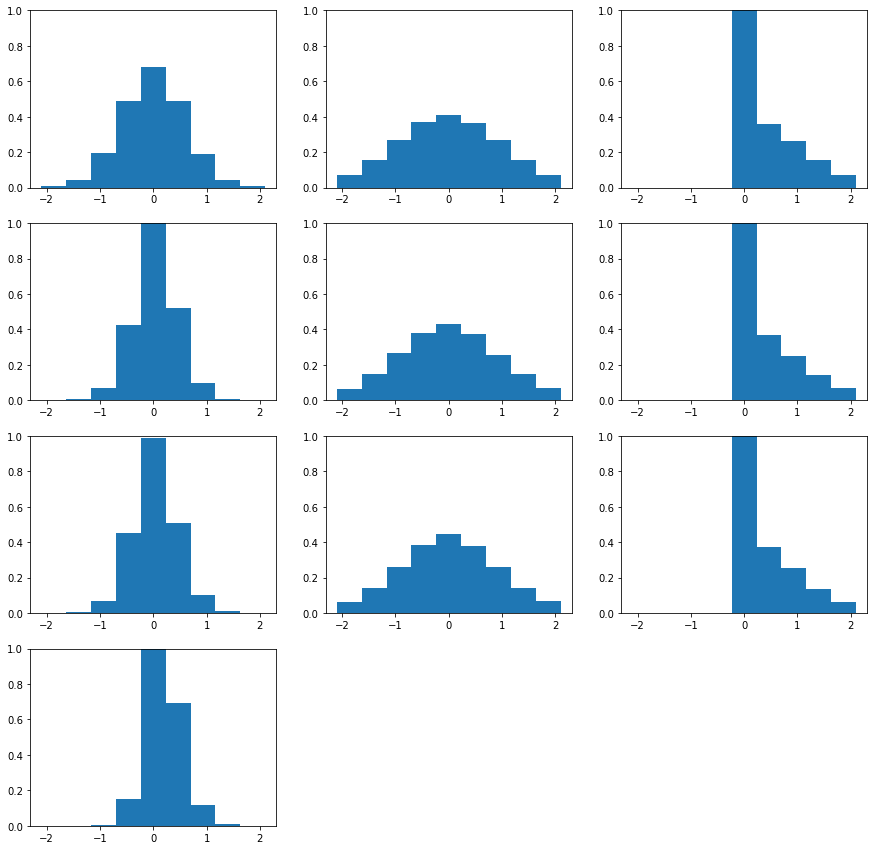

In [32]:
x = torch.randn(1000, 10)
net = Network()

hooks = []
activations = []
hook_fun = track_activations(activations)

for layer in net.layers:
    hook = layer.register_forward_hook(hook_fun)
    hooks.append(hook)

with torch.no_grad():
    res = net(x)

for hook in hooks:
    hook.remove()
    
plt.figure(figsize=(15, 15))

for i, act in enumerate(activations):
    plt.subplot(4, 3, i+1)
    plt.hist(act.reshape(-1).numpy(), bins=9, density=True, range=(-2.1,2.1))
    plt.gca().set_ylim(0, 1)
plt.show()

## Pros and Cons for both methods:
- **Weight Initalization:**
    - Pro: Minimal computation overhead; Con: Effect wears off the deeper you go
- **BatchNorm:**
    - Pro: Can be applied even at deep layers; Con: Expensive operation

### Take-Home Assignment 2:
- Try incorporating BatchNorm layers and different weight initialisation in your MNIST training code. Play around with deep networks with and without said techniques and exhibit how the loss changes. 

In [33]:
class FullyConnectedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(in_features=28*28, out_features=32)
        self.input_relu = nn.ReLU()
        self.hidden_1_linear = nn.Linear(in_features=32, out_features=32)
        self.hidden_1_relu = nn.ReLU()
        self.hidden_2_linear = nn.Linear(in_features=32, out_features=32)
        self.hidden_2_batchnorm = nn.BatchNorm1d(num_features=32)
        self.hidden_2_relu = nn.ReLU()
        self.output_layer = nn.Linear(32, 10)
    
    def forward(self, x):
        x = x.reshape(-1, 28*28)
        x = self.input_layer(x)
        x = self.input_relu(x)
        x = self.hidden_1_linear(x)
        x = self.hidden_1_relu(x)
        x = self.hidden_2_linear(x)
        x = self.hidden_2_batchnorm(x)
        x = self.hidden_2_relu(x)
        x = self.output_layer(x)
        return x

In [34]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

lr = 0.1
epochs = 10

loss_fun = nn.CrossEntropyLoss()
network = FullyConnectedNet()
optimizer = torch.optim.Adam(network.parameters(), lr)

# transforms.Compose = combine different transformations which should be on all instances
transform=transforms.Compose([
    transforms.ToTensor(),
    # Applies Z-Score normalisation on data (mean and std of MNIST dataset)
    transforms.Normalize((0.1307,), (0.3081,))
])

# weight initalization
network.apply(init_weights)

train_set = MNIST('data', download=True, transform=transform)
val_set = MNIST('data', train=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)
val_loader = DataLoader(val_set, batch_size=100, shuffle=False)
        
train_loop_schedule(train_loader, val_loader, network, loss_fun, optimizer, epochs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Epoch: 1/10; Training loss: 0.3898112177848816; Validation loss 0.27868813276290894
Epoch: 2/10; Training loss: 0.25290828943252563; Validation loss 0.22320622205734253
Epoch: 3/10; Training loss: 0.2176360785961151; Validation loss 0.20076848566532135
Epoch: 4/10; Training loss: 0.19657307863235474; Validation loss 0.21705175936222076
Epoch: 5/10; Training loss: 0.18939712643623352; Validation loss 0.17763887345790863
Epoch: 6/10; Training loss: 0.17530956864356995; Validation loss 0.18481600284576416
Epoch: 7/10; Training loss: 0.16230031847953796; Validation loss 0.22428786754608154
Epoch: 8/10; Training loss: 0.15697772800922394; Validation loss 0.16873012483119965
Epoch: 9/10; Training loss: 0.148495152592659; Validation loss 0.18567512929439545
Epoch: 10/10; Training loss: 0.14667008817195892; Validation loss 0.19929273426532745
